In [1]:
from term_grouping import *
from print_cliques import print_cliques
import matplotlib.pyplot as plt
from collections import Counter
import time
import numpy as np
import glob
from openfermion.hamiltonians import MolecularData
from openfermion.transforms import get_fermion_operator, get_interaction_operator
from openfermionpsi4 import run_psi4
from openfermion.transforms import (jordan_wigner, bravyi_kitaev, bravyi_kitaev_fast, bravyi_kitaev_tree,
                                    binary_code_transform, reverse_jordan_wigner)
from openfermion.utils import group_into_tensor_product_basis_sets
from openfermion.transforms._binary_codes import parity_code

plt.rcParams["font.size"] = 13
plt.rcParams["axes.labelsize"] = 15
plt.rcParams["axes.titlesize"] = 15
plt.rcParams["font.family"] = 'sans-serif'
plt.rcParams["xtick.labelsize"] = 13
plt.rcParams["ytick.labelsize"] = 13

### Generate benchmark hamiltonians for the OpenFermion algorithm
OpenFermion's minclique cover takes a QubitHamiltonian as input so these need to be generated 
separately from the hamiltonians in the the hamiltonians/ directory.

In [2]:
def load_transform_group(filename, encoding_AS_dict):
    # Load molecule from file
    print('--- loading molecule ---')
    molecule = MolecularData(filename=filename)
    print('filename: {}'.format(molecule.filename))
    print('--- compute integrals ---')
    molecule = run_psi4(molecule,run_mp2=True,run_cisd=True,run_ccsd=True,run_fci=True)
    
    #print(molecule.two_body_integrals)
    #print(molecule.canonical_orbitals)
    #print('n_atoms: {}'.format(molecule.n_atoms))
    #print('n_electrons: {}'.format(molecule.n_electrons))
    #print('n_orbitals: {}'.format(molecule.n_orbitals))
    #print('Canonical Orbitals: {}'.format(molecule.canonical_orbitals))
    #print('n_qubits: {}'.format(molecule.n_qubits))
    
    # construct Hamiltonian for each pair of transform-AS in encoding_AS_dict
    data = []
    for transform in encoding_AS_dict.keys():
        print('\n>>>> Using {} transform'.format(transform))
        all_orbital_pairs = encoding_AS_dict[transform]
        for orbital_pair in all_orbital_pairs:
            
            occupied_num, active_num = orbital_pair
            print('ActiveSpace = {}'.format(active_num))
            
            # Construct Hamiltonian
            molecular_hamiltonian = molecule.get_molecular_hamiltonian(
                                    occupied_indices=range(occupied_num),
                                    active_indices=range(active_num))
    
            # map the operator to fermions and then qubits
            fermion_hamiltonian = get_fermion_operator(molecular_hamiltonian)
    
            # get interaction operator (needed for BKSF)
            interaction_hamiltonian = get_interaction_operator(fermion_hamiltonian)
    
            if transform is 'JW':
                qubit_h = jordan_wigner(fermion_hamiltonian)
                qubit_h.compress()
            elif transform is 'BK':
                qubit_h = bravyi_kitaev(fermion_hamiltonian)
                qubit_h.compress()
            elif transform is 'BKSF':
                qubit_h = bravyi_kitaev_fast(interaction_hamiltonian)
                qubit_h.compress()
            elif transform is 'BKT':
                qubit_h = bravyi_kitaev_tree(fermion_hamiltonian)
                qubit_h.compress()
            elif transform is 'PC':
                qubit_h = binary_code_transform(fermion_hamiltonian, parity_code(2*active_num))
                qubit_h.compress()
            else:
                print('ERROR: Unrecognized qubit transformation: {}'.format(transform))
                sys.exit(2)
                
            num_terms = len(qubit_h.terms.keys()) - 1
            print('OPENFERMION: generated Hamiltonian with {} terms (excluding Identity)'.format(num_terms))
                
            # Use OpenFermion function to group into commuting sets using QWC
            # time the computation
            start_time = time.time()
            cliques = group_into_tensor_product_basis_sets(qubit_h)
            end_time = time.time()
            
            print('OPENFERMION: group_into_tensor_product_basis_sets found {} unique circuits'.format(len(cliques)))
            et = end_time - start_time
            print('OPENFERMION: Elapsed time: {:.6f}s'.format(et))
            
            data.append((num_terms,len(cliques),et))
            
    return data

In [49]:
ch4filename = 'molecule_data/CH4_sto-3g_singlet_grnd.hdf5'
ch4dict = {'BK': [(9,1),(9,2),(9,3),(9,4),(9,5),(9,6),(9,7),(9,8),(9,9)]}

h2filename1 = 'molecule_data/H2_6-31g_singlet_0.7.hdf5'
h2dict1 = {'BK': [(4,1),(4,2),(4,3),(4,4)],
           'BKSF': [(4,4)], 'BKT': [(4,4)],
           'JW': [(4,1),(4,2),(4,3),(4,4)],
           'PC': [(4,4)]}

h2filename2 = 'molecule_data/H2_sto-3g_singlet_0.7.hdf5'
h2dict2 = {'BK': [(2,1),(2,2)]}

h2ofilename1 = 'molecule_data/H2O_6-31g_singlet_104.hdf5'
h2odict1 = {'BK': [(6,1),(6,2),(6,3),(6,4),(6,5),(6,6)],
           'BKSF': [(6,6)], 'BKT': [(6,6)],
           'JW': [(6,6)],
           'PC': [(6,6)]}

h2ofilename2 = 'molecule_data/H2O_sto-3g_singlet_104.hdf5'
h2odict2 = {'BK': [(6,1),(6,2),(6,3),(6,4),(6,5),(6,6)]}

lihfilename = 'molecule_data/LiH_sto-3g_singlet_1.45.hdf5'
lihdict = {'BK': [(6,1),(6,2),(6,3),(6,4),(6,5),(6,6)]}

filelist = [ch4filename, h2filename1, h2filename2, h2ofilename1, h2ofilename2, lihfilename]
dictlist = [ch4dict,     h2dict1,     h2dict2,     h2odict1,     h2odict2,     lihdict]

all_data = []
for fname, encode_dict in zip(filelist,dictlist):
    cur_data = load_transform_group(fname, encode_dict)
    all_data.append(cur_data)

--- loading molecule ---
filename: molecule_data/CH4_sto-3g_singlet_grnd
--- compute integrals ---

>>>> Using BK transform
ActiveSpace = 1
OPENFERMION: generated Hamiltonian with 3 terms (excluding Identity)
OPENFERMION: group_into_tensor_product_basis_sets found 1 unique circuits
OPENFERMION: Elapsed time: 0.001992s
ActiveSpace = 2
OPENFERMION: generated Hamiltonian with 26 terms (excluding Identity)
OPENFERMION: group_into_tensor_product_basis_sets found 8 unique circuits
OPENFERMION: Elapsed time: 0.002163s
ActiveSpace = 3
OPENFERMION: generated Hamiltonian with 93 terms (excluding Identity)
OPENFERMION: group_into_tensor_product_basis_sets found 33 unique circuits
OPENFERMION: Elapsed time: 0.003411s
ActiveSpace = 4
OPENFERMION: generated Hamiltonian with 240 terms (excluding Identity)
OPENFERMION: group_into_tensor_product_basis_sets found 70 unique circuits
OPENFERMION: Elapsed time: 0.010487s
ActiveSpace = 5
OPENFERMION: generated Hamiltonian with 591 terms (excluding Identity)


>>>> Using BK transform
ActiveSpace = 1
OPENFERMION: generated Hamiltonian with 3 terms (excluding Identity)
OPENFERMION: group_into_tensor_product_basis_sets found 1 unique circuits
OPENFERMION: Elapsed time: 0.002077s
ActiveSpace = 2
OPENFERMION: generated Hamiltonian with 26 terms (excluding Identity)
OPENFERMION: group_into_tensor_product_basis_sets found 8 unique circuits
OPENFERMION: Elapsed time: 0.002313s
ActiveSpace = 3
OPENFERMION: generated Hamiltonian with 117 terms (excluding Identity)
OPENFERMION: group_into_tensor_product_basis_sets found 40 unique circuits
OPENFERMION: Elapsed time: 0.004573s
ActiveSpace = 4
OPENFERMION: generated Hamiltonian with 192 terms (excluding Identity)
OPENFERMION: group_into_tensor_product_basis_sets found 55 unique circuits
OPENFERMION: Elapsed time: 0.007850s
ActiveSpace = 5
OPENFERMION: generated Hamiltonian with 275 terms (excluding Identity)
OPENFERMION: group_into_tensor_product_basis_sets found 65 unique circuits
OPENFERMION: Elapsed t

In [50]:
# write results to file
with open('Data/openfermion_clique_cover_results.txt', 'w') as fn:
    for dset in all_data:
        for run in dset:
            nterms, ncliques, runtime = run
            fn.write('{0} {1} {2:.6f}\n'.format(str(nterms).ljust(5), str(ncliques).ljust(5), runtime))

# Plot benchmarks
Benchmarks are organized:
--------------------------------
0 -> BH_QWC

1 -> BH_FULL

2 -> BK_QWC

3 -> BK_FULL

4 -> OP_QWC


In [2]:
bh_qwc_bmarks_fn = glob.glob('Data/Bopp*QWC*')
bh_full_bmarks_fn = glob.glob('Data/Bopp*FULL*')
bk_qwc_bmarks_fn = glob.glob('Data/Bron*QWC*')
bk_full_bmarks_fn = glob.glob('Data/Bron*FULL*')
op_qwc_bmarks_fn = glob.glob('Data/openfermion*clique*')
bmarks_fn = [bh_qwc_bmarks_fn, bh_full_bmarks_fn, bk_qwc_bmarks_fn, bk_full_bmarks_fn, op_qwc_bmarks_fn]

In [3]:
for bm in bmarks_fn:
    print(bm)

['Data/BoppanaHalldorsson_QWC_5237term_results.txt', 'Data/BoppanaHalldorsson_QWC_1519term_results.txt', 'Data/BoppanaHalldorsson_QWC_1495term_results.txt', 'Data/BoppanaHalldorsson_QWC_1495term_results1.txt', 'Data/BoppanaHalldorsson_QWC_3006term_results.txt', 'Data/BoppanaHalldorsson_QWC_results.txt', 'Data/BoppanaHalldorsson_QWC_8484term_results.txt']
['Data/BoppanaHalldorsson_FULL_results.txt', 'Data/BoppanaHalldorsson_FULL_5237term_results.txt', 'Data/BoppanaHalldorsson_FULL_1519term_results.txt', 'Data/BoppanaHalldorsson_FULL_1495term_results.txt', 'Data/BoppanaHalldorsson_FULL_3006term_results.txt', 'Data/BoppanaHalldorsson_FULL_8484term_results.txt']
['Data/BronKerbosch_QWC_1519term_results.txt', 'Data/BronKerbosch_QWC_results.txt']
[]
['Data/openfermion_clique_cover_results.txt']


In [4]:
bmarks = []
for bm in bmarks_fn:
    first = True
    for fn in bm:
        print(fn)
        if first == True:
            temp_bm = np.array(np.genfromtxt(fn))
            first = False
        else:
            temp_bm = np.vstack((temp_bm,np.genfromtxt(fn)))
    bmarks.append((temp_bm))

Data/BoppanaHalldorsson_QWC_5237term_results.txt
Data/BoppanaHalldorsson_QWC_1519term_results.txt
Data/BoppanaHalldorsson_QWC_1495term_results.txt
Data/BoppanaHalldorsson_QWC_1495term_results1.txt
Data/BoppanaHalldorsson_QWC_3006term_results.txt
Data/BoppanaHalldorsson_QWC_results.txt
Data/BoppanaHalldorsson_QWC_8484term_results.txt
Data/BoppanaHalldorsson_FULL_results.txt
Data/BoppanaHalldorsson_FULL_5237term_results.txt
Data/BoppanaHalldorsson_FULL_1519term_results.txt
Data/BoppanaHalldorsson_FULL_1495term_results.txt
Data/BoppanaHalldorsson_FULL_3006term_results.txt
Data/BoppanaHalldorsson_FULL_8484term_results.txt
Data/BronKerbosch_QWC_1519term_results.txt
Data/BronKerbosch_QWC_results.txt
Data/openfermion_clique_cover_results.txt


In [5]:
print(len(bmarks))

5


In [6]:
def func(x, a, b, c):
    return a * np.exp(-b * x) + c

In [7]:
low = []
high = []
low.append([-1,-2,-3,-4])
high.append([1,2,3,4])
print(low[0],'\n',high[0])
errs = np.stack((low[0],high[0]))
print(errs)

[-1, -2, -3, -4] 
 [1, 2, 3, 4]
[[-1 -2 -3 -4]
 [ 1  2  3  4]]


In [17]:
def return_with_errors(xvals, yvals):
    val_dict = {}
    for x1,y1 in zip(xvals, yvals):
        try:
            val_dict[str(x1)].append(y1)
        except KeyError:
            val_dict[str(x1)] = [y1]
            
    real_xvals, real_yvals, min_err, max_err = [], [], [], []
    for k in sorted(val_dict.keys(), key=lambda term: float(term)):
        #print('{}: {}'.format(k,val_dict[k]))
        real_xvals.append(float(k))
        mean = np.mean(val_dict[k])
        real_yvals.append(mean)
        min_err.append(mean - min(val_dict[k]))
        max_err.append(max(val_dict[k]) - mean)
    err = np.stack((min_err,max_err))
    
    return real_xvals, real_yvals, err

In [30]:
def lin_func(x, m, b):
    return [m * xx + b for xx in x]

In [31]:
def exp_func(x, a, b, c, d, e):
    return [b * a**(c * xx + d) + e for xx in x]

/Users/teague/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:2: RuntimeWarning: overflow encountered in double_scalars
  


[[ 1.05759953e+04 -1.45974696e+08 -8.13904651e+06  6.80457470e+08
  -3.95212534e+04]
 [-2.76475864e+08  2.82466977e+14  2.12769690e+11 -1.68692950e+16
   1.04142541e+09]
 [-8.13904657e+06  1.12338947e+11  6.26362594e+09 -5.23672262e+11
   3.04146687e+07]
 [ 8.57255848e+09 -1.69698289e+16 -6.59725449e+12  1.01965195e+18
  -3.25346485e+10]
 [-3.95251257e+04  5.53811306e+08  3.04176485e+07 -3.04304240e+09
   1.54578807e+05]]
[[ 1.50245148e+00  1.11085140e+06 -5.48546468e+03 -1.43545930e+08
  -6.82497618e+02]
 [ 1.04060764e+06 -4.10957765e+14 -3.79921427e+09  3.79136334e+16
  -3.78894488e+08]
 [-5.48546467e+03 -4.05567490e+09  2.00274838e+07  5.24082562e+11
   2.49180884e+06]
 [-1.37060616e+08  3.79117172e+16  5.00404619e+11 -3.49649218e+18
   5.35996949e+10]
 [-6.82481613e+02 -4.10791306e+08  2.49175041e+06  5.65441588e+10
   3.21328744e+05]]
[[ 1.40054306e+04  4.42377429e+07 -1.68417290e+07 -8.58687230e+09
  -1.77499406e+03]
 [ 7.29641073e+07  2.76605437e+12 -8.77403587e+10 -5.62588554e+

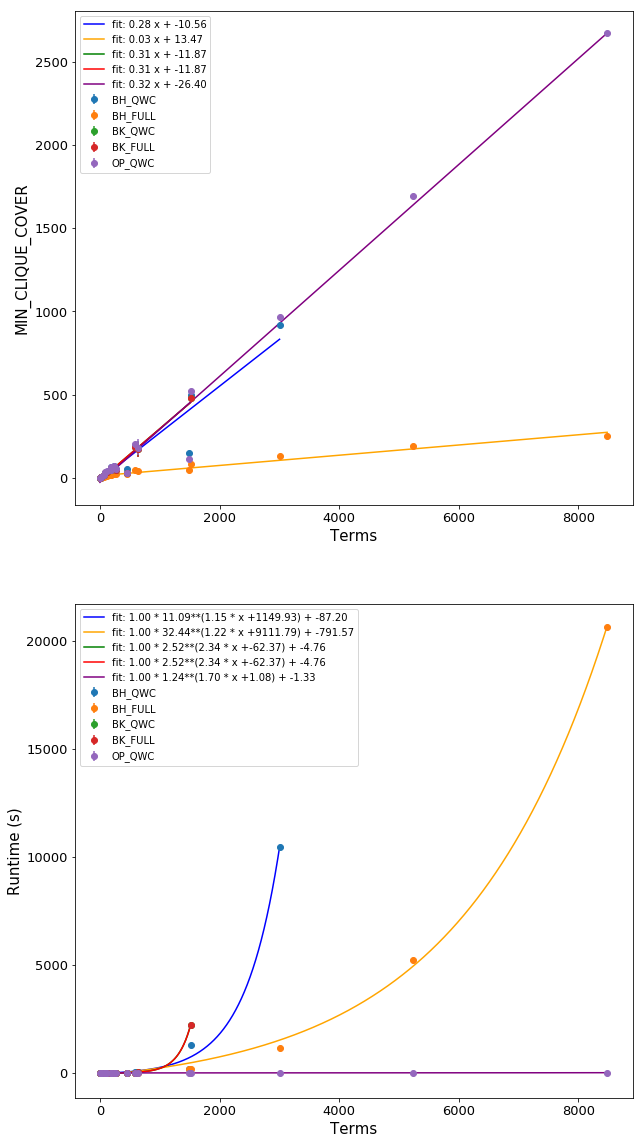

In [42]:
# Plotting
from scipy.optimize import curve_fit
fig, ax = plt.subplots(nrows=2,ncols=1,figsize=(10,20))

labels = ['BH_QWC','BH_FULL','BK_QWC','BK_FULL','OP_QWC']
c = ['blue','orange','green','red','purple']

for i, bm in enumerate(bmarks):
    terms_temp = bm[:,0]
    cliques_temp = bm[:,1]
    runtime_temp = bm[:,2]
    
    # Sort the benchmarks and get their errors
    terms, cliques, clique_err = return_with_errors(terms_temp, cliques_temp)
    _, runtime, runtime_err = return_with_errors(terms_temp, runtime_temp)
    
    # print the benchmarks
    #for n in range(len(terms)):
    #    print('{}: {} [{},{}]'.format(terms[n], cliques[n], clique_err[0][n], clique_err[1][n]))
    
    # Fit the benchmarks to linear and exponential funcs
    fit_x = np.arange(0,terms[-1],2)
    
    cpopt, cpcov = curve_fit(lin_func, terms, cliques)
    
    ax[0].plot(fit_x, lin_func(fit_x, *cpopt),c=c[i],label='fit: {:.2f} x + {:.2f}'.format(*cpopt))
    
    rpopt, rpcov = curve_fit(exp_func, terms, runtime)
    print(rpcov)
    ax[1].plot(fit_x, exp_func(fit_x, *rpopt),c=c[i],
               label='fit: {:.2f} * {:.2f}**({:.2f} * x +{:.2f}) + {:.2f}'.format(*rpopt))
    
    ax[0].errorbar(terms,cliques,yerr=[clique_err[0],clique_err[1]],fmt='o',label=labels[i])
    ax[0].set_ylabel('MIN_CLIQUE_COVER')
    ax[0].set_xlabel('Terms')
    ax[0].legend()
    
    ax[1].errorbar(terms,runtime,yerr=[runtime_err[0],runtime_err[1]],fmt='o',label=labels[i])
    ax[1].set_ylabel('Runtime (s)')
    ax[1].set_xlabel('Terms')
    ax[1].legend()

In [36]:
print(cpopt)

[  0.31825539 -26.40222628]
